# Import data
- load data
- get an overview of the data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [19]:
df = pd.read_csv('datasets/train.csv', parse_dates=['pickup_datetime', 'dropoff_datetime'])
test = pd.read_csv('datasets/test.csv', parse_dates=['pickup_datetime'])

In [20]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [22]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [23]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  625134 non-null  object        
 1   vendor_id           625134 non-null  int64         
 2   pickup_datetime     625134 non-null  datetime64[ns]
 3   passenger_count     625134 non-null  int64         
 4   pickup_longitude    625134 non-null  float64       
 5   pickup_latitude     625134 non-null  float64       
 6   dropoff_longitude   625134 non-null  float64       
 7   dropoff_latitude    625134 non-null  float64       
 8   store_and_fwd_flag  625134 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 42.9+ MB


# Helper functions

In [192]:
def corr_heatmap(df):
    corr_matrix = df.corr()
    mask = np.triu(np.ones_like(corr_matrix))
    sns.heatmap(corr_matrix, annot=True, mask=mask)
def outlier_viz(df):
    print(df.describe())
    num_cols = list(df.select_dtypes('number').columns)  
    # create a square of subplots
    square_size = int(len(num_cols)**0.5+1)
    assert square_size**2 >= len(num_cols), 'outlier_viz: wrong square size logic'
    # plot boxplot for each num feat
    fig, ax = plt.subplots(square_size, square_size, figsize=(square_size*5,square_size*5))
    ax = ax.flatten()
    current_plot = 0
    for i in range(len(num_cols)):
        sns.boxplot(data=df, x=num_cols[i], ax=ax[i])
    plt.suptitle('Outliers visualization')
    plt.show()
def drop_zero_records(df, cols:list=None):
    # drop records with 0 in the columns specified 
    if not cols:
        cols = df.select_dtypes('number').columns
    temp_df = df.copy()
    dtypes = dict(df.dtypes)
    for col in cols:
        temp_df.loc[temp_df[col]==0, [col]] = np.nan
        temp_df.dropna(axis=0, subset=[col], inplace=True)
    return temp_df.astype(dtypes) # int cols will get converted to float when replacing nulls
def drop_statistical_outliers(df, cols:list=None):
    # drop records with outlying values in the columns specified
    # outliers are further than 3 SDs from the mean
    if not cols:
        cols = df.select_dtypes('number').columns
    temp_df = df.copy()
    col_stats = {col:(temp_df[col].mean(), temp_df[col].std()) for col in cols}
    for col in cols:
        col_lower = col_stats[col][0] - 3*col_stats[col][1] 
        col_upper = col_stats[col][0] + 3*col_stats[col][1] 
        temp_df = temp_df[(temp_df[col] < col_upper) & (temp_df[col] > col_lower)]
    return temp_df
def drop_outliers_minmax(df, col, min_to_keep, max_to_keep):
    raise NotImplementedError

In [193]:
drop_zero_records(pd.DataFrame({'col1': [1, 2, 0], 'col2': [0, 3, 4]}))

,col1,col2
1,2,3


In [194]:
drop_statistical_outliers(pd.DataFrame({'col1': [1, 2], 'col2': [3, 4]}))

,col1,col2
0,1,3
1,2,4


# Clean data
- convert to correct datatypes
- check for duplicates
- replacing nulls and filtering out outliers
- feature selection by variance and correlation

In [83]:
assert not df.duplicated().any(), 'Duplicate records found'

In [84]:
df.isna().any()

id                    False
vendor_id             False
pickup_datetime       False
dropoff_datetime      False
passenger_count       False
pickup_longitude      False
pickup_latitude       False
dropoff_longitude     False
dropoff_latitude      False
store_and_fwd_flag    False
trip_duration         False
dtype: bool

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01

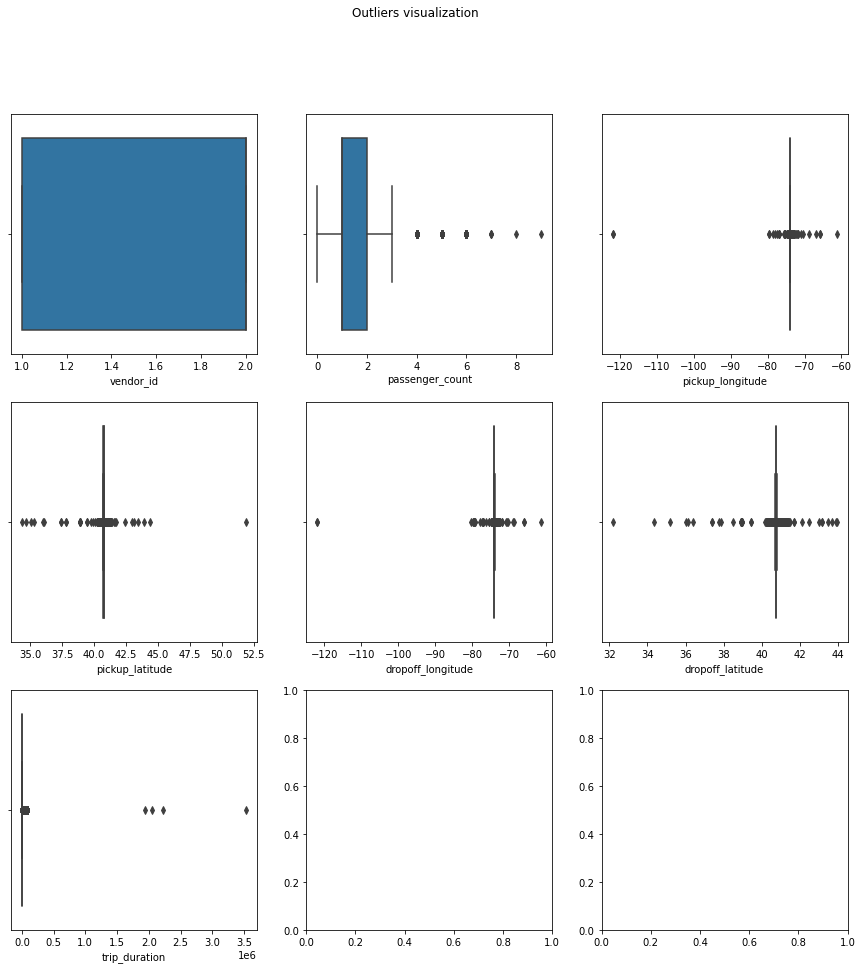

In [85]:
outlier_viz(df)

In [195]:
# passenger_count --> 0 passengers
# longtitude and latitude should be somewhat within NYC's vicinity --> longtitude have min max like frim -120,-60 very weird
# trip duration (seconds) --> max of 3.5 million need to remove outliers

# remove zero passenger
df = drop_zero_records(df, ['passenger_count'])
# remove statistical outliers
df = drop_statistical_outliers(df)
# remove outlying trip duration

          vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.361116e+06     1.361116e+06      1.361116e+06     1.361116e+06   
mean   1.517561e+00     1.513992e+00     -7.397779e+01     4.075328e+01   
std    4.996917e-01     1.057215e+00      2.561877e-02     2.301852e-02   
min    1.000000e+00     1.000000e+00     -7.418407e+01     4.065229e+01   
25%    1.000000e+00     1.000000e+00     -7.399213e+01     4.073883e+01   
50%    2.000000e+00     1.000000e+00     -7.398209e+01     4.075491e+01   
75%    2.000000e+00     2.000000e+00     -7.396871e+01     4.076866e+01   
max    2.000000e+00     5.000000e+00     -7.376234e+01     4.084953e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.361116e+06      1.361116e+06   1.361116e+06  
mean       -7.397505e+01      4.075261e+01   7.878104e+02  
std         3.100411e-02      2.876118e-02   5.764901e+02  
min        -7.418524e+01      4.064413e+01   1.000000e+00  
25%        -7.399142e+01

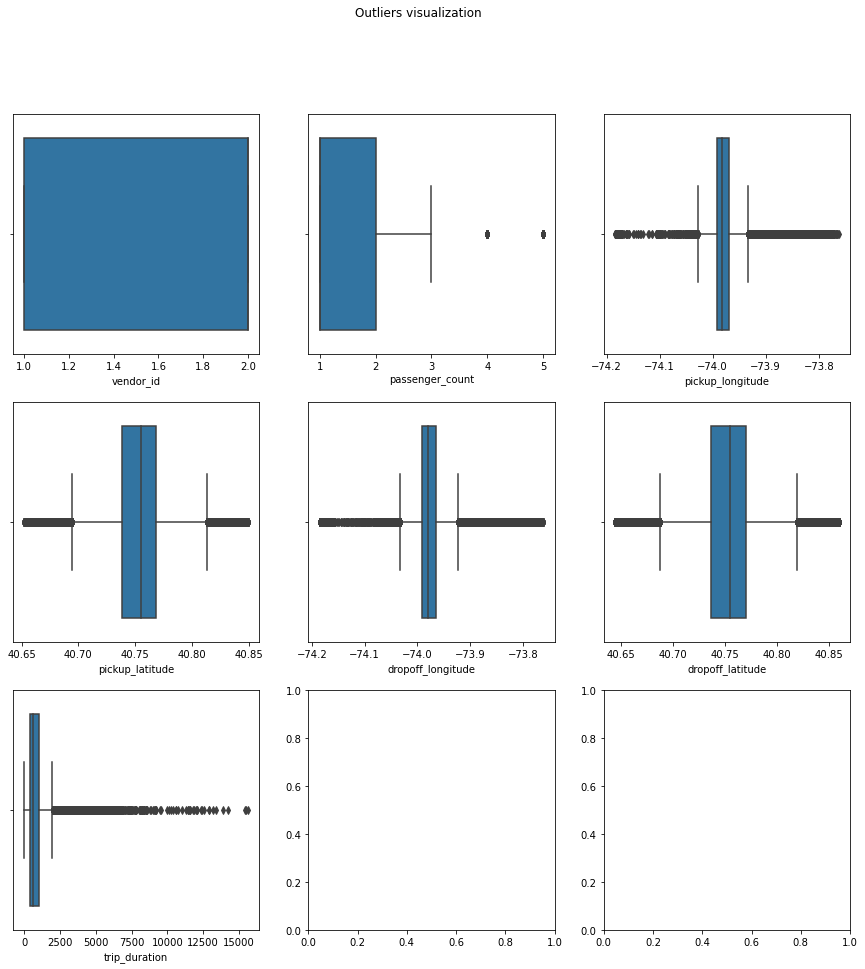

In [196]:
outlier_viz(df)

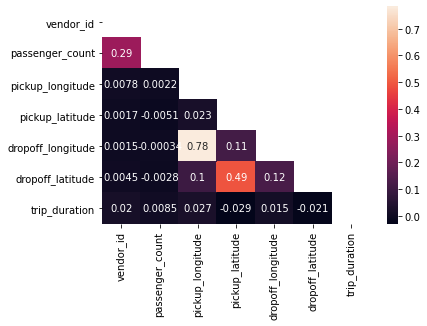

In [33]:
corr_heatmap(df)

# understandable that longtitudes and latitudes have some kind of correlation since they are in the same region

# EDA to get insights

# Feature Engineering

## Target variable

## Categorical features

## Numeric features
- make sure that they comply to stats assumptions

# Preprocessing
- select features to feed into model (create a pipeline so we tweak with feature selection)
- preprocessing pipeline from df -> X,y
    - scaling and 
- train --> train & validate split

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Model selection
- define metric
- select models
- cross validate --> select the most promising

# Hyperparameters tuning

# Train with tuned hyperparams and predict with unseen test data